<h1>Potion Concoction</h1>

<h2>Game Description</h2>
In the world of alchemy, creating powerful potions is both an art and a science. In this puzzle game, the agent is challenged to mix a sequence of magical ingredients to craft a target potion. However, the rules of alchemical interaction are not always known in advance. Some ingredient combinations may result in success, while others could produce ineffective mixtures or dangerous explosions.
The agent must experiment, reason, and adapt within a constrained environment, such as a limited number of actions or ingredients. This setup simulates decision-making under uncertainty and highlights the value of agents capable of planning, learning, and reacting dynamically. By modeling this puzzle, we aim to design an intelligent agent that can solve the potion task efficiently without violating the constraints imposed by the environment.

**insert graph to show weighted scores taken to reach optimal path**

<h2>Problem Definitions</h2>

Implementing the potion concoction in code and defining the game rules clearly, because those rules define:
1. What actions the agent can take
2. How states change after actions
3. What makes a state valid, invalid, or goal
4. How to calculate cost, similarity score, and constraints

<h2>Environment Setup</h2>

The environment for this simulation is designed using a network graph that models how a potion evolves through a series of chemical additions and random disturbances. It serves as a simplified abstraction of decision-making under uncertainty and time constraints.

<h3>States</h3>
Each state is a 3-tuple (r, b, y) representing the quantity of:
r: Red chemical
b: Blue chemical
y: Yellow chemical
We defined the initial state as (0, 0, 0) - a completely neutral (white) potion.
We defined the goal state as (20, 0, 20), representing the ideal target composition.

<h3>Action Space</h3>
From any given state, the agent can choose to:
1. Add Red (R) – increases r by 20.
2. Add Blue (B) – increases b by 20.
3. Add Yellow (Y) – increases y by 20.
4. Trigger a Random Event – introduces uncertainty by randomly reducing each color component by 0 or 20.

Each action transitions the environment to a new state, forming the edges of the state graph.

<h3>Edge Weights</h3>
Each edge in the graph is assigned a weight that reflects the cost of the corresponding action. The base cost of any action is 1. Additional penalties are applied based on two factors:
    1. Overshooting Penalty: If the resulting state has any chemical value exceeding 20, a penalty of +3 is added to the edge weight to discourage inefficient use of chemicals.
    2. Distance Penalty: If the new state moves the potion further away from the goal state (measured using Manhattan distance), an additional +1 is added.

These weighted edges simulate the consequences of suboptimal decisions and allow search algorithms like Uniform Cost Search to find more efficient action sequences that reach the goal with minimal cost.

<h3>Game Rules Abstraction</h3>
To simplify the game, the environment is constrained to four discrete rounds. In each round, all potion states generated in the previous round are expanded using a fixed action space—adding red, blue, or yellow chemicals, or triggering a random event. The inclusion of this random event introduces non-determinism, as it unpredictably reduces chemical values, making some state transitions uncertain. Despite this stochastic element, the state space remains discrete and finite, as chemical quantities change in fixed increments. This structure allows for clear visual mapping and systematic analysis of all possible potion evolution paths.

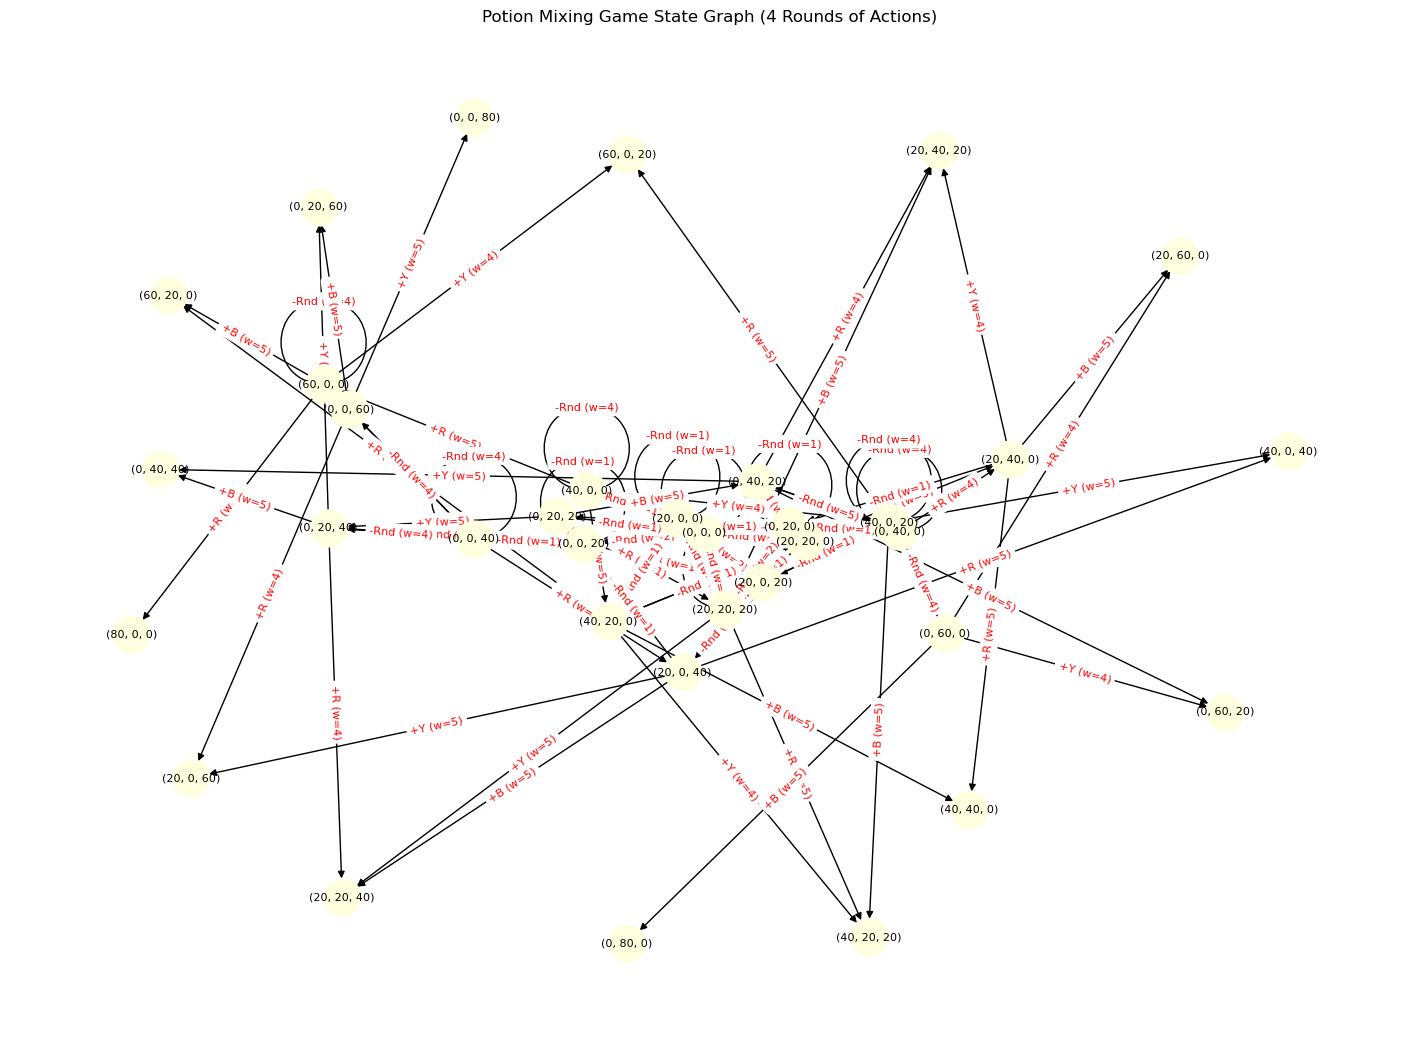

Print some sample edges to validate if weights have been applied:
(0, 0, 0) -> (20, 0, 0), label: +R, weight: 1
(0, 0, 0) -> (0, 20, 0), label: +B, weight: 2
(0, 0, 0) -> (0, 0, 20), label: +Y, weight: 1
(0, 0, 0) -> (0, 0, 0), label: -Rnd, weight: 1
(20, 0, 0) -> (40, 0, 0), label: +R, weight: 5


In [50]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Create a directed graph
G = nx.DiGraph()

# Initial state
start = (0, 0, 0)
G.add_node(start)

# Reference potion
reference = (20, 0, 20)
goal = reference

# Function to apply an action
def apply_action(state, action):
    r, b, y = state
    if action == 'R':
        return (r + 20, b, y)
    elif action == 'B':
        return (r, b + 20, y)
    elif action == 'Y':
        return (r, b, y + 20)

# Function to simulate a random decrease
def random_event(state):
    rand_decrease = lambda v: max(0, v - random.choice([0, 20, 20]))
    r, b, y = state
    return (rand_decrease(r), rand_decrease(b), rand_decrease(y))

# Assigns weights to each edge
def get_action_cost(current, next_state):
    r1, b1, y1 = current
    r2, b2, y2 = next_state

    # Base cost for any action
    cost = 1

    # Penalty if any component overshoots 20
    if r2 > 20 or b2 > 20 or y2 > 20:
        cost += 3

    # Distance to goal before and after the action
    dist_before = abs(r1 - reference[0]) + abs(b1 - reference[1]) + abs(y1 - reference[2])
    dist_after  = abs(r2 - reference[0]) + abs(b2 - reference[1]) + abs(y2 - reference[2])

    if dist_after > dist_before:
        cost += 1  # penalty for moving away from goal

    return cost

# Build the graph with 4 rounds of actions
rounds = 4
states_by_round = {0: [start]}

for i in range(1, rounds + 1):
    states_by_round[i] = []
    for state in states_by_round[i - 1]:
        # Three chemical actions
        for action in ['R', 'B', 'Y']:
            new_state = apply_action(state, action)
            G.add_node(new_state)
            weight = get_action_cost(state, new_state)
            G.add_edge(state, new_state, label=f'+{action}', weight=weight)
            states_by_round[i].append(new_state)
        
        # One random event
        rnd_state = random_event(state)
        G.add_node(rnd_state)
        rnd_weight = get_action_cost(state, rnd_state)
        G.add_edge(state, rnd_state, label='-Rnd', weight=rnd_weight)
        states_by_round[i].append(rnd_state)

# Visualize the graph
pos = nx.spring_layout(G, seed=42)  # consistent layout
edge_labels = {(u, v): f"{d['label']} (w={d['weight']})" for u, v, d in G.edges(data=True)}

plt.figure(figsize=(14, 10))
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightyellow', font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

plt.title("Potion Mixing Game State Graph (4 Rounds of Actions)")
plt.show()

# Visual check to validate weights are applied
print("Print some sample edges to validate if weights have been applied:")
for u, v, d in list(G.edges(data=True))[:5]:
    print(f"{u} -> {v}, label: {d['label']}, weight: {d['weight']}")


<h4>Decluttered Visualisation</h4>
This is the same network graph representing the potion-mixing game, but we’ve enhanced the visualization by decluttering the densely connected center to improve readability. By spacing out the nodes using a spring layout and adjusting edge thickness and color based on action cost, the graph now clearly highlights how different paths evolve across rounds.

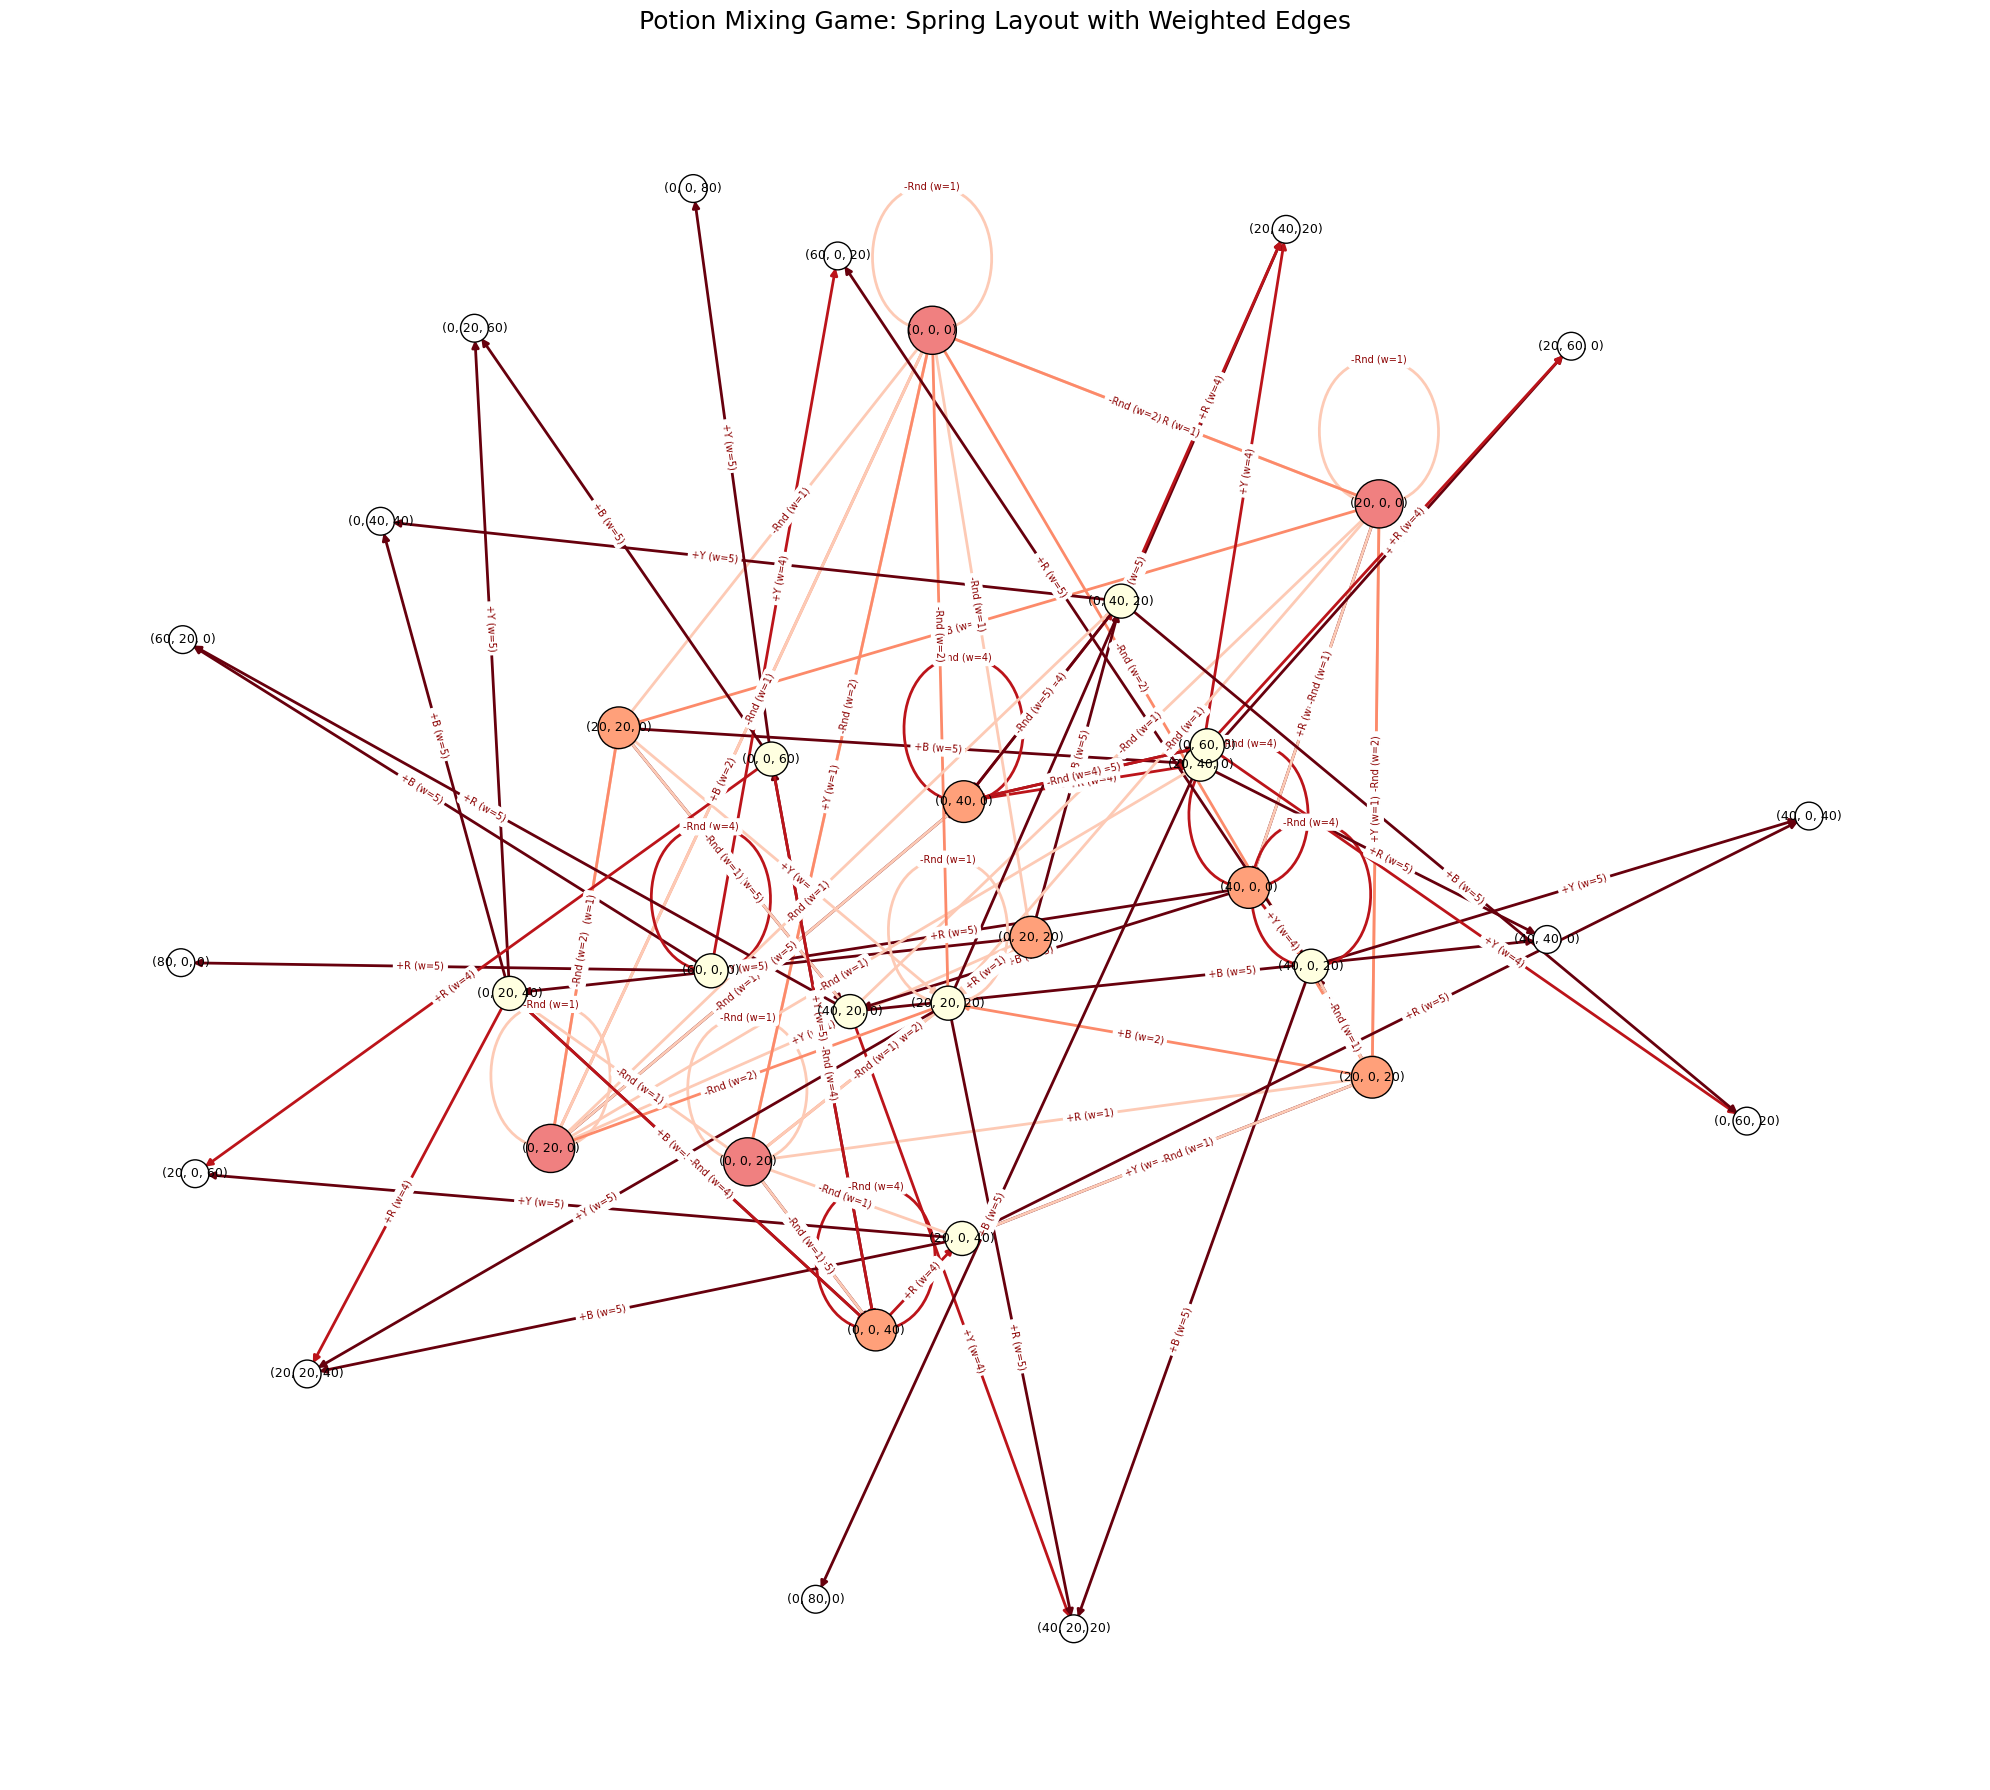

In [51]:
import matplotlib.pyplot as plt
import networkx as nx

# Use spring layout with more spacing between nodes
pos = nx.spring_layout(G, seed=42, k=1.5)  # higher k = more spacing

# Define color map and size based on round
node_sizes = []
node_colors = []
for node in G.nodes():
    if node in states_by_round[0] or node in states_by_round[1]:
        node_sizes.append(1200)
        node_colors.append('lightcoral')
    elif node in states_by_round[2]:
        node_sizes.append(900)
        node_colors.append('lightsalmon')
    elif node in states_by_round[3]:
        node_sizes.append(600)
        node_colors.append('lightyellow')
    else:
        node_sizes.append(400)
        node_colors.append('white')

# Optional: Edge weights as thickness
edge_widths = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(edge_widths)
edge_colors = [plt.cm.Reds(weight / max_weight) for weight in edge_widths]

# Draw graph
plt.figure(figsize=(20, 18))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')
nx.draw_networkx_edges(G, pos, arrows=True, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(G, pos, font_size=9)

# Draw edge labels (action + weight)
edge_labels = {
    (u, v): f"{d['label']} (w={d['weight']})" for u, v, d in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, font_color='darkred', label_pos=0.55)

plt.title("Potion Mixing Game: Spring Layout with Weighted Edges", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()


<h2>Algorithm #1: Breadth First Search (BFS)</h2>

Breadth-First Search (BFS) is used to find the shortest sequence of actions—from the starting state (0, 0, 0)—that leads to the target potion state (20, 0, 20). At each round, BFS expands all possible states generated in the previous round by applying every available action: adding red, blue, or yellow chemicals, or triggering a random reduction event. By exploring states in layers, round by round, BFS ensures that the first time it encounters the goal state, it has found the minimum number of steps required to reach it. This is particularly useful in our setup with a limited action space and four discrete rounds, where identifying the most efficient path to the target composition is critical.

In [52]:
from collections import deque

def weighted_breadth_first_search(graph, start, goal):
    visited = set()
    queue = deque([([start], 0)])  # (path_so_far, cumulative_weight)

    while queue:
        path, cost = queue.popleft()
        node = path[-1]

        if node == goal:
            return path, cost

        if node in visited:
            continue
        visited.add(node)

        for neighbor in graph.successors(node):
            edge_weight = graph.edges[node, neighbor].get('weight', 1)
            new_path = list(path) + [neighbor]
            new_cost = cost + edge_weight
            queue.append((new_path, new_cost))

    return None, float('inf')

bfs_path, bfs_cost = weighted_breadth_first_search(G, start, goal)
print("BFS Path (min steps):", bfs_path)
print("Total Weight Along Path:", bfs_cost)


BFS Path (min steps): [(0, 0, 0), (20, 0, 0), (20, 0, 20)]
Total Weight Along Path: 2


<h2>Algorithm #2: Depth First Search (DFS)</h2>

Depth-First Search (DFS) explores action sequences by diving deep into one possible path of potion transformations before backtracking. Starting from the initial state (0, 0, 0), DFS applies a single action—such as adding red, blue, or yellow chemicals, or triggering a random event—and continues expanding the resulting state down one branch until it reaches the maximum depth of four rounds or a terminal state. Only then does it backtrack to explore alternative paths. 

While DFS is not guaranteed to find the shortest path to the target potion (20, 0, 20), it can be faster in finding a solution in large state spaces, especially if the goal lies deep in one specific branch. However, due to the non-deterministic random event and the structure of this game, DFS may easily miss optimal paths or become inefficient without backtracking heuristics.

In [53]:
def depth_first_search(graph, start, goal):
    visited = set()
    stack = [([start], 0)]  # (path_so_far, cumulative_weight)

    while stack:
        path, cost = stack.pop()
        node = path[-1]

        if node == goal:
            return path, cost

        if node in visited:
            continue
        visited.add(node)

        for neighbor in graph.successors(node):
            edge_weight = graph.edges[node, neighbor].get('weight', 1)
            new_path = list(path) + [neighbor]
            new_cost = cost + edge_weight
            stack.append((new_path, new_cost))

    return None, float('inf')

dfs_path, dfs_cost = depth_first_search(G, start, goal)
print("DFS Path:", dfs_path)
print("Total Weight Along Path:", dfs_cost)


DFS Path: [(0, 0, 0), (0, 0, 20), (0, 0, 40), (20, 0, 40), (20, 0, 20)]
Total Weight Along Path: 11


<h2>Algorithm #3: Uniform Cost Search</h2>

Uniform Cost Search (UCS) is used to find the least costly sequence of actions to reach the target potion state (20, 0, 20) from the starting state (0, 0, 0). Unlike BFS, which treats all actions equally, UCS expands states based on the accumulated cost of reaching them, always selecting the path with the lowest total cost so far. In this context, each chemical addition or random event can be treated as having a uniform cost (e.g., 1), or assigned different weights if certain actions are considered more resource-intensive or risky. UCS is particularly well-suited for environments like this one where actions have varying impacts, and where it’s important not just to reach the goal, but to do so in the most efficient or least risky way.

In [54]:
import heapq

def uniform_cost_search(graph, start, goal):
    visited = set()
    # Each item in queue: (cumulative_cost, path_so_far)
    queue = [(0, [start])]

    while queue:
        cost, path = heapq.heappop(queue)
        node = path[-1]

        if node == goal:
            return path, cost

        if node in visited:
            continue
        visited.add(node)

        for neighbor in graph.successors(node):
            edge_weight = graph.edges[node, neighbor].get('weight', 1)
            new_cost = cost + edge_weight
            new_path = path + [neighbor]
            heapq.heappush(queue, (new_cost, new_path))

    return None, float('inf')

ucs_path, ucs_cost = uniform_cost_search(G, start, goal)
print("UCS Path:", ucs_path)
print("Total Cost:", ucs_cost)


UCS Path: [(0, 0, 0), (0, 0, 20), (20, 0, 20)]
Total Cost: 2


In [45]:
# Algorithm #4: Depth-Limited Search
# Algorithm #5: Iterative Deepening
# Algorithm #6: Greedy Algorithm
# Algorithm #7: A*Search Algorithm